<a href="https://colab.research.google.com/github/Nour543/NLP-Project/blob/main/My_NLP_Project___2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@inproceedings{hateoffensive,
  title = {Automated Hate Speech Detection and the Problem of Offensive Language},
  author = {Davidson, Thomas and Warmsley, Dana and Macy, Michael and Weber, Ingmar}, 
  booktitle = {Proceedings of the 11th International AAAI Conference on Web and Social Media},
  series = {ICWSM '17},
  year = {2017},
  location = {Montreal, Canada},
  pages = {512-515}
  }
~~~

https://github.com/t-davidson/hate-speech-and-offensive-language/

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Installs
#!pip install spellchecker
!pip install pyspellchecker
!pip install vaderSentiment
!pip install transformers
!pip install torchtext
!pip install sentencepiece

     |████████████████████████████████| 2.7 MB 5.0 MB/s 
     |████████████████████████████████| 125 kB 5.0 MB/s 
     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 59.3 MB/s 
     |████████████████████████████████| 3.3 MB 51.3 MB/s 
     |████████████████████████████████| 56 kB 5.3 MB/s 
     |████████████████████████████████| 895 kB 59.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.1 MB/s 


In [3]:
# Libraries / Imports

from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from spellchecker import SpellChecker
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from __future__ import print_function

import transformers
from transformers import pipeline, AutoTokenizer, BertTokenizer, TFBertModel, AlbertTokenizer, TFAlbertModel

import tensorflow as tf
from tensorflow import keras


from keras import layers, models, optimizers
from keras.models import Sequential
from keras.preprocessing import text, sequence 
from keras.layers import Embedding, GlobalMaxPool1D, GlobalAveragePooling1D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.datasets import imdb
from keras.utils import np_utils

import nltk
from nltk import word_tokenize , sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import PorterStemmer

import torch
from torchtext import data
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import decomposition, ensemble, model_selection, preprocessing, linear_model, naive_bayes, metrics, svm


In [4]:
# Downloads

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# Import data
 
df1 = pd.read_csv('/content/drive/MyDrive/labeled_data.csv', delimiter=',') 
df1.head()

FileNotFoundError: ignored

In [ ]:
selected_columns = df1[["tweet","class"]]

df = selected_columns.copy()

df.rename(columns = {'class': 'Hsbinary'}, inplace = True)

df['Hsbinary']=df['Hsbinary'].replace(0,'off', regex=True)
df['Hsbinary']=df['Hsbinary'].replace(1,'off', regex=True)
df['Hsbinary']=df['Hsbinary'].replace(2,'ok', regex=True)

df['Hsbinary']=df['Hsbinary'].replace('off',1, regex=True)
df['Hsbinary']=df['Hsbinary'].replace('ok',0, regex=True)

df.head()

,tweet,Hsbinary
0,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


1. Use any of the hate speech/cyberbullying databases maintained at http://hatespeechdata.com/. In addition, there is two additional cyberbullying datasets available at https://github.com/saroarjahan/Negation_project/, AskFm and FormSpring, which can be used as well. We would like to investigate the structure of the dataset in terms of the categories present. Consider the subclass S1 of hate/cyberbullying content and subclass S2 of non-abusive content. Draw a word-cloud representation of S1 and S2 and explain the word features.

In [ ]:
df['Hsbinary'].value_counts()

1    20620
0     4163
Name: Hsbinary, dtype: int64

In [ ]:
# Making subclasses S1: abusive content (class = 1), S2: non abusive content(class = 0)
S1 = df[df['Hsbinary']==1]
#S1.to_csv("not_ok.csv")

S2 = df[df['Hsbinary']==0]
#S2.to_csv("ok.csv")

In [ ]:
#S1.head()
#S2.head()

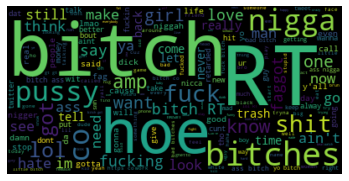

In [ ]:
# Wordcloud 1: abusive
text_S1 = " ".join(t for t in S1.tweet)
wordcloud = WordCloud().generate(text_S1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

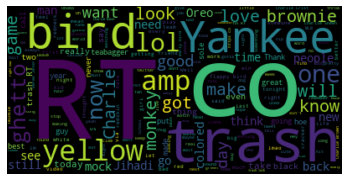

In [ ]:
# Wordcloud 2: non abusive
text_S2 = " ".join(t for t in S2.tweet)
wordcloud = WordCloud().generate(text_S2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# split into training/ test data

#X: Feature data
X = df['tweet']

#y: class
y = df['Hsbinary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Pipeline: TF-IDF Vectorizer + LR Classifier , data before processing
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LogisticRegression()),
])

#X_train = df_train['tweet_processed']
text_clf.fit(X_train, y_train)

# Form a prediction set
predictions = text_clf.predict(X_test)

# Report the confusion matrix
from sklearn import metrics
print("Confusion Matrix:  \n", metrics.confusion_matrix(y_test,predictions))

# Print a classification report
print("Classification Report:  \n", metrics.classification_report(y_test,predictions))

#Accuracy Score
print("Accuracy Score:  " , metrics.accuracy_score(y_test, predictions))

# F1 Score
print("F1 Score:  ", metrics.f1_score(y_test, predictions))

Confusion Matrix:  
 [[ 831  430]
 [ 126 6048]]
Classification Report:  
               precision    recall  f1-score   support

           0       0.87      0.66      0.75      1261
           1       0.93      0.98      0.96      6174

    accuracy                           0.93      7435
   macro avg       0.90      0.82      0.85      7435
weighted avg       0.92      0.93      0.92      7435

Accuracy Score:   0.9252185608607936
F1 Score:   0.9560543787543471


2.a. Perform dataset pre-processing examples stop-word removal, stemming, special character removal, emoji removal, number, hashtag, mention tag, etc. Report different preprocessing outcome and try to explain the results. 

In [ ]:
df_train = pd.DataFrame(list(zip(X_train, y_train)), columns =['tweet', 'Hsbinary'])
df_train.to_csv("train_raw.csv")
#files.download('train_raw.csv')

df_test = pd.DataFrame(list(zip(X_test, y_test)), columns =['tweet', 'Hsbinary'])
df_test.to_csv("test.csv")
#files.download('test.csv')

In [ ]:
df_train.head()

,tweet,Hsbinary
0,Charlie Jacobs got confused about the ice buck...,0
1,@JuanNDaCut @ShareA40Ounce she playin pussy ho...,1
2,I be telling Mcgirt music ain't enough.You got...,1
3,@IHateStevenSing\nI ain't to show bout dem col...,0
4,RT @blessedarti: Y'all claim you want a good &...,1


In [ ]:
# remove mention urls, tags and hashtags

def clean1(txt):
  cleantext = re.sub('@[A-Za-z0-9]+', '', txt)
  return cleantext

def clean2(txt):
  cleantext = re.sub('#[A-Za-z0-9]+', '', txt)
  return cleantext

def clean3(txt):
  cleantext = re.sub('http\S+|www.\S+', '', txt)
  return cleantext

In [ ]:
df_train['tweet_processed'] = df_train['tweet'].apply(lambda X: clean1(X))

#df_train.head()

In [ ]:
df_train['tweet_processed'] = df_train['tweet_processed'].apply(lambda X: clean2(X))

#df_train.head()

In [ ]:
df_train['tweet_processed'] = df_train['tweet_processed'].apply(lambda X: clean3(X))

#df_train.head()

In [ ]:
# Removing unnecessary whitespaces
def remove_whitespace(text):
    return  " ".join(text.split())

df_train['tweet_processed'] = df_train['tweet_processed'].apply(remove_whitespace)

In [ ]:
# Tokenization
df_train['tweet_processed'] = df_train['tweet_processed'].apply(lambda X: word_tokenize(X))

In [ ]:
# # Remove proper nouns (Should maybe replace with named entity 'person'? ~mention tags)

# df_train['pos']=df_train['tweet_processed'].apply(nltk.pos_tag)

# def prop_list(text):
#   prop_words = []
#   for (word, tag) in text:
#     if tag == 'NNP': 
#       prop_words.append(word)
#   return prop_words
  

# propw = df_train['pos'].apply(lambda X: prop_list(X))
# propn = [item for sublist in propw for item in sublist]
# #print(propn)

# def remove_prop(text):
#     result = []
#     for token in text:
#         if token not in propn:
#             result.append(token)
#     return result

# df_train['tweet_processed'] = df_train['tweet_processed'].apply(remove_prop)

In [ ]:
df_train.head()

,tweet,Hsbinary,tweet_processed
0,Charlie Jacobs got confused about the ice buck...,0,"[Charlie, Jacobs, got, confused, about, the, i..."
1,@JuanNDaCut @ShareA40Ounce she playin pussy ho...,1,"[she, playin, pussy, hole, bingo, ., She, draw..."
2,I be telling Mcgirt music ain't enough.You got...,1,"[I, be, telling, Mcgirt, music, ai, n't, enoug..."
3,@IHateStevenSing\nI ain't to show bout dem col...,0,"[I, ai, n't, to, show, bout, dem, colored, dia..."
4,RT @blessedarti: Y'all claim you want a good &...,1,"[RT, :, Y'all, claim, you, want, a, good, &, a..."


In [ ]:
# OPTIONAL, TAKES A FEW MINS #########################

# def spell_check(text):
    
#     result = []
#     spell = SpellChecker()
#     for word in text:
#         correct_word = spell.correction(word)
#         result.append(correct_word)
    
#     return result

# df_train['tweet_processed'] = df_train['tweet_processed'].apply(spell_check)

In [ ]:
en_stopwords = stopwords.words('english')
en_stopwords.remove('not')

def remove_stopwords(text):
    result = []
    for token in text:
        if token not in en_stopwords:
            result.append(token)
            
    return result

df_train['tweet_processed'] = df_train['tweet_processed'].apply(remove_stopwords)

In [ ]:
# Stemming (keep?)

def stemming(text):
    porter = PorterStemmer()
    
    result=[]
    for word in text:
        result.append(porter.stem(word))
    return result

df_train['tweet_processed'] = df_train['tweet_processed'].apply(stemming)

In [ ]:
# remove special characters and numbers

def remove_punct(text):
    
    tokenizer = RegexpTokenizer(r"\w+")
    lst=tokenizer.tokenize(' '.join(text))
    return lst

df_train['tweet_processed'] = df_train['tweet_processed'].apply(remove_punct)

In [ ]:
# Detokenization

df_train['tweet_processed'] = df_train['tweet_processed'].apply(lambda X: TreebankWordDetokenizer().detokenize(X))
df_train.head(10)

,tweet,Hsbinary,tweet_processed
0,Charlie Jacobs got confused about the ice buck...,0,Charlie Jacobs got confused ice bucket challen...
1,@JuanNDaCut @ShareA40Ounce she playin pussy ho...,1,playin pussy hole bingo She drawing next number
2,I be telling Mcgirt music ain't enough.You got...,1,I telling Mcgirt music ai n t enough You gotta...
3,@IHateStevenSing\nI ain't to show bout dem col...,0,I ai n t show bout dem colored diamonds talk d...
4,RT @blessedarti: Y'all claim you want a good &...,1,RT Y all claim want good amp loyal girl keep m...
5,Thats not ya bitch if she dont love giving you...,1,Thats not ya bitch dont love giving head
6,Yall couldn't wAit till Halloween to dress up ...,1,Yall could n t wAit till Halloween dress like ...
7,&#8220;@Thatindianbruh: Food &gt; Pussy \n\nbu...,1,Food gt Pussy pussy Food food pussy
8,RT @CockyBelichick: Time for the comeback puss...,1,RT Time comeback pussies
9,RT @ruckin_andrew: This bitch has a death grip...,1,RT _andrew This bitch death grip niggas balls Smh


In [ ]:
df_train['tweet_processed'].str.lower()

0        charlie jacobs got confused ice bucket challen...
1          playin pussy hole bingo she drawing next number
2        i telling mcgirt music ai n t enough you gotta...
3        i ai n t show bout dem colored diamonds talk d...
4        rt y all claim want good amp loyal girl keep m...
                               ...                        
17343    the last at bat yankee stadium thanks making g...
17344    _bradleey lmfaoooo yooo i lost elevator pass i...
17345                 hardcore british queer anal pounding
17346    rt just i thought justin bieber could n t anym...
17347                           bitches shit saying nothin
Name: tweet_processed, Length: 17348, dtype: object

In [ ]:
X_train = df_train['tweet_processed']
df_train_pro = pd.DataFrame(list(zip(X_train, y_train)), columns =['tweet', 'Hsbinary'])
df_train_pro.to_csv("train_pro.csv")
#files.download('train_pro.csv')

2.b. Use simple LR classifier and tf-idf as feature representation for different pre-processing performance comparisons. Use best pre-processing for rest of the  experiments.

In [ ]:
# Pipeline: TF-IDF Vectorizer + LR Classifier

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LogisticRegression()),
])

X_train = df_train['tweet_processed']
text_clf.fit(X_train, y_train)

# Form a prediction set
predictions = text_clf.predict(X_test)

# Report the confusion matrix
print("Confusion Matrix:  \n", metrics.confusion_matrix(y_test,predictions))

# Print a classification report
print("Classification Report:  \n", metrics.classification_report(y_test,predictions))

#Accuracy Score
print("Accuracy Score:  " , metrics.accuracy_score(y_test, predictions))

# F1 Score
print("F1 Score:  ", metrics.f1_score(y_test, predictions))

Confusion Matrix:  
 [[ 808  453]
 [ 217 5957]]
Classification Report:  
               precision    recall  f1-score   support

           0       0.79      0.64      0.71      1261
           1       0.93      0.96      0.95      6174

    accuracy                           0.91      7435
   macro avg       0.86      0.80      0.83      7435
weighted avg       0.91      0.91      0.91      7435

Accuracy Score:   0.9098856758574311
F1 Score:   0.9467577876668786


3. Perform Sentiment analysis of each of the posts and get positive, negative, or neutral scores. You can use sentiment Vader (https://github.com/cjhutto/vaderSentiment). Use this sentiment score as a feature and report classification Accuracy and F1 score by using simple Logistic Regression as classifier and sentiment score as a feature. Dou you think sentiment analysis can be used as feature? 

In [ ]:
# # VADER, raw data + evaluation
 
# sid = SentimentIntensityAnalyzer()
   
# df_train['scores'] = df_train['tweet'].apply(lambda t: sid.polarity_scores(t))

# df_train['compound']  = df_train['scores'].apply(lambda score_dict: score_dict['compound'])

# df_train['comp_score'] = df_train['compound'].apply(lambda c: 0 if c >=0 else 1)

# #df_train.head(10) 


# print("Confusion Matrix:  \n", metrics.confusion_matrix(df_train['Hsbinary'],df_train['comp_score']))

# # Print a classification report
# print("Classification Report:  \n", metrics.classification_report(df_train['Hsbinary'],df_train['comp_score']))

# #Accuracy Score
# print("Accuracy Score:  " , metrics.accuracy_score(df_train['Hsbinary'],df_train['comp_score']))

# # F1 Score
# print("F1 Score:  ", metrics.f1_score(df_train['Hsbinary'],df_train['comp_score']))

Confusion Matrix:  
 [[2155  747]
 [4669 9777]]
Classification Report:  
               precision    recall  f1-score   support

           0       0.32      0.74      0.44      2902
           1       0.93      0.68      0.78     14446

    accuracy                           0.69     17348
   macro avg       0.62      0.71      0.61     17348
weighted avg       0.83      0.69      0.73     17348

Accuracy Score:   0.6878026285450772
F1 Score:   0.7830997196635963


In [ ]:
# VADER, processed data
 
sid = SentimentIntensityAnalyzer()
   
df_train['scores'] = df_train['tweet_processed'].apply(lambda t: sid.polarity_scores(t))

df_train['compound']  = df_train['scores'].apply(lambda score_dict: score_dict['compound'])

df_train['comp_score'] = df_train['compound'].apply(lambda c: 0 if c >=0.15 else 1)

#df_train.head(10)   

print("Confusion Matrix:  \n", metrics.confusion_matrix(df_train['Hsbinary'],df_train['comp_score']))

# Print a classification report
print("Classification Report:  \n", metrics.classification_report(df_train['Hsbinary'],df_train['comp_score']))

#Accuracy Score
print("Accuracy Score:  " , metrics.accuracy_score(df_train['Hsbinary'],df_train['comp_score']))

# F1 Score
print("F1 Score:  ", metrics.f1_score(df_train['Hsbinary'],df_train['comp_score']))

Confusion Matrix:  
 [[ 1077  1825]
 [ 2259 12187]]
Classification Report:  
               precision    recall  f1-score   support

           0       0.32      0.37      0.35      2902
           1       0.87      0.84      0.86     14446

    accuracy                           0.76     17348
   macro avg       0.60      0.61      0.60     17348
weighted avg       0.78      0.76      0.77     17348

Accuracy Score:   0.7645838136961033
F1 Score:   0.8564902663574391


In [ ]:
df_train[['scores', 'compound', 'Hsbinary', 'comp_score']].head(50)

,scores,compound,Hsbinary,comp_score
0,"{'neg': 0.327, 'neu': 0.588, 'pos': 0.085, 'co...",-0.5719,0,1
1,"{'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'comp...",0.0772,1,1
2,"{'neg': 0.0, 'neu': 0.936, 'pos': 0.064, 'comp...",0.0772,1,1
3,"{'neg': 0.155, 'neu': 0.728, 'pos': 0.117, 'co...",-0.2023,0,1
4,"{'neg': 0.1, 'neu': 0.476, 'pos': 0.424, 'comp...",0.7579,1,0
5,"{'neg': 0.401, 'neu': 0.371, 'pos': 0.228, 'co...",-0.3252,1,1
6,"{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp...",0.3612,1,0
7,"{'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'comp...",0.2732,1,0
8,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1,1
9,"{'neg': 0.724, 'neu': 0.276, 'pos': 0.0, 'comp...",-0.9201,1,1


In [ ]:
# # Pipeline: TF-IDF Vectorizer + LR Classifier , feature = sentiment score

# text_clf = Pipeline([('dict', DictVectorizer()),
#                      ('tfid', TfidfTransformer()),
#                      ('clf', LogisticRegression()),
# ])

# X_train_sent = df_train['scores']
# text_clf.fit(X_train_sent, y_train)

# # Form a prediction set
# predictions = text_clf.predict(X_test)

# # Report the confusion matrix
# print("Confusion Matrix:  \n", metrics.confusion_matrix(y_test,predictions))

# # Print a classification report
# print("Classification Report:  \n", metrics.classification_report(y_test,predictions))

# #Accuracy Score
# print("Accuracy Score:  " , metrics.accuracy_score(y_test, predictions))

# # F1 Score
# print("F1 Score:  ", metrics.f1_score(y_test, predictions))

AttributeError: ignored

4. Run classification with LR and tf-itdf as a baseline model so that you can compare the result with other state-of-the-art practices. Study the implementation available at https://github.com/pinkeshbadjatiya/twitter-hatespeech of the paper "Deep learning for hate speech detection Tweets" by Pinkesh Badjatiya (www'17 proceedings, 2017) report result of the Accuracy and F1 score. Try to implement CNN+fastText architecture.

In [ ]:
train_x= df_train['tweet_processed']
valid_x= df_test['tweet']
train_y= df_train['Hsbinary']
valid_y= df_test['Hsbinary']

comment=train_x

In [ ]:
print('train comments length: ',len(train_x))
print('test comments length: ',len(valid_x))

train comments length:  17348
test comments length:  7435


In [ ]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(comment)
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)


# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(comment)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x)

In [ ]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('/content/drive/MyDrive/wiki-news-300d-1M.vec', encoding="utf8")):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(comment)
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure e
# qual length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
def train_model(classifier, xtrain, ytrain, xvalid, yvalid): 
    # fit the training dataset on the classifier
    classifier.fit(xtrain, ytrain)
    # predict the labels on validation dataset
    predictions = classifier.predict(xvalid)     
    accuracy = metrics.accuracy_score(predictions, yvalid)
    f1score = metrics.f1_score(yvalid, predictions, average='weighted')
    return accuracy, f1score

In [ ]:
# # Linear Classifier on Word Level TF IDF Vectors
# accuracy, f1score = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf, valid_y)
# print("LR, WordLevel TF-IDF:   accuracy: %s   f1 score: %s"% (accuracy,f1score))

# # Linear Classifier on Character Level TF IDF Vectors
# accuracy, f1score = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y)
# print("LR, CharLevel Vectors:   accuracy: %s   f1 score: %s"% (accuracy,f1score))

In [ ]:
# convert to one_hot

train_y_onehot = keras.utils.to_categorical(train_y, 3)
valid_y_onehot = keras.utils.to_categorical(valid_y, 3)

In [ ]:
train_y_onehot

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
def cnn(xtrain, ytrain, xvalid, yvalid, epochs = 10):
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(3, activation="softmax")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
    model.fit(xtrain, ytrain,
              batch_size=256,
              epochs=epochs)
    predictions = model.predict(xvalid)
    predictions = predictions.argmax(axis=-1)
    accuracy = model.evaluate(xvalid, yvalid, verbose=0)
    f1score = metrics.f1_score(valid_y, predictions, average='weighted')
    return accuracy, f1score

In [ ]:
accuracy, f1score = cnn(train_seq_x, train_y_onehot, valid_seq_x, valid_y_onehot)
print("CNN, Word Embeddings acuuracy accuracy:%s     f1 score: %s"% (accuracy[1], f1score))

Epoch 1/10
68/68 [==============================] - 12s 157ms/step - loss: 0.3312 - accuracy: 0.8618
Epoch 2/10
68/68 [==============================] - 11s 156ms/step - loss: 0.1934 - accuracy: 0.9107
Epoch 3/10
68/68 [==============================] - 11s 162ms/step - loss: 0.1676 - accuracy: 0.9276
Epoch 4/10
68/68 [==============================] - 11s 160ms/step - loss: 0.1521 - accuracy: 0.9342
Epoch 5/10
68/68 [==============================] - 11s 160ms/step - loss: 0.1408 - accuracy: 0.9397
Epoch 6/10
68/68 [==============================] - 11s 159ms/step - loss: 0.1287 - accuracy: 0.9504
Epoch 7/10
68/68 [==============================] - 11s 159ms/step - loss: 0.1155 - accuracy: 0.9530
Epoch 8/10
68/68 [==============================] - 11s 160ms/step - loss: 0.1076 - accuracy: 0.9577
Epoch 9/10
68/68 [==============================] - 11s 160ms/step - loss: 0.0955 - accuracy: 0.9633
Epoch 10/10
68/68 [==============================] - 11s 160ms/step - loss: 0.0841 - accura

In [ ]:
####################### FastText #######################

def create_ngram_set(input_list, ngram_value=2):
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

# Set parameters:
# ngram_range = 2 will add bi-grams features
ngram_range = 2
max_features = 20000
maxlen = 400
batch_size = 32
embedding_dims = 50
epochs = 5

In [ ]:
if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    
    xtrain_lst =  X_train.tolist()
    xtest_lst =  X_test.tolist()
    
    for input_list in xtrain_lst:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(xtrain_lst, token_indice, ngram_range)
    x_test = add_ngram(xtest_lst, token_indice, ngram_range)
    #print('Average train sequence length: {}'.format(
    #    np.mean(list(map(len, x_train)), dtype=int)))
    #print('Average test sequence length: {}'.format(
    #    np.mean(list(map(len, x_test)), dtype=int)))

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(x_train, maxlen=maxlen)
X_test = sequence.pad_sequences(x_test, maxlen=maxlen)
#print('x_train shape:', x_train.shape)
#print('x_test shape:', x_test.shape)

Adding 2-gram features
Pad sequences (samples x time)


In [ ]:
model = Sequential()

model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 400, 50)           5044700   
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 5,044,751
Trainable params: 5,044,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_train, y_train, verbose=2)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/5
543/543 - 28s - loss: 0.4695 - accuracy: 0.8327 - val_loss: 0.4553 - val_accuracy: 0.8304
Epoch 2/5
543/543 - 28s - loss: 0.4489 - accuracy: 0.8327 - val_loss: 0.4539 - val_accuracy: 0.8304
Epoch 3/5
543/543 - 28s - loss: 0.4460 - accuracy: 0.8327 - val_loss: 0.4531 - val_accuracy: 0.8304
Epoch 4/5
543/543 - 28s - loss: 0.4417 - accuracy: 0.8327 - val_loss: 0.4508 - val_accuracy: 0.8304
Epoch 5/5
543/543 - 28s - loss: 0.4363 - accuracy: 0.8327 - val_loss: 0.4484 - val_accuracy: 0.8304
543/543 - 1s - loss: 0.4314 - accuracy: 0.8327
Training Accuracy: 0.8327
233/233 - 0s - loss: 0.4484 - accuracy: 0.8304
Testing Accuracy:  0.8304


In [ ]:
y_pred1 = model.predict(X_test)
y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
print('Precision = ', precision_score(y_test, y_pred , average="macro"))
print('Recall = ', recall_score(y_test, y_pred , average="macro"))
print('F1 Score = ', f1_score(y_test, y_pred , average="macro"))

Precision =  0.0848016139878951
Recall =  0.5
F1 Score =  0.14500919963201472


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5. Run sate-of-the-art practices BERT model, example  BERT-base-uncased and BERT-multilingual, report both model Accuracy and F1 score. Scripts available on GitHub page https://github.com/saroarjahan/Negation_project/ . Student are open to experimenting with other BERT models, for example, BERT related specifically to hate. Different BERT models can be found here https://huggingface.co/models .

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
model = transformers.BertModel.from_pretrained("bert-base-multilingual-uncased")

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.eval()
if torch.cuda.is_available():
    model = model.cuda()

In [ ]:
bert=model

In [ ]:
#check if gpu exists
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
#Read the data 
train = pd.read_csv("train_pro.csv")
valid = pd.read_csv("test.csv")

FileNotFoundError: ignored

In [ ]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('Hsbinary', label_field),('tweet', text_field)]

# TabularDataset

train, valid= TabularDataset.splits( path="", train='train_pro.csv', validation='test.csv',
                                            format='CSV', fields=fields, skip_header=True)


# Iterators

train_iter = BucketIterator(train, batch_size=4, sort_key=lambda x: len(x.tweet),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=4, sort_key=lambda x: len(x.tweet),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(valid, batch_size=4, device=device, train=False, shuffle=False, sort=False)

In [ ]:
train_iter

In [ ]:
class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(768,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 4
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 172,481,025 trainable parameters


In [ ]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,124,609 trainable parameters


In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.tweet).squeeze(1)
        # print(predictions)
        
        loss = criterion(predictions, batch.Hsbinary)
        
        acc = binary_accuracy(predictions, batch.Hsbinary)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.tweet).squeeze(1)
            
            loss = criterion(predictions, batch.Hsbinary)
            
            acc = binary_accuracy(predictions, batch.Hsbinary)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'bert-base-multilingual-uncased.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

KeyboardInterrupt: ignored

In [ ]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

In [ ]:
def predict_sentiment(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:512-2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    sentiment=np.round(prediction.item())
    return sentiment

In [ ]:
predict_sentiment(model, tokenizer, "you are fuck")

6. We would like to test the above 4,5 implementation at least for two different datasets. Students are welcome to experiment with more datasets. Try to explain your result of Accuracy and F1 score for the above experiment for 4, 5, which are mainly LR+tf-idf, CNN+fastText, BERT-base-uncased and BERT-multilingual.

7. Negation dataset generation: In this part, students perform negation dataset generation of the previous training dataset. A possible negation detection and augmentation algorithm could be as: Load a sentence. First, perform negation findings by using NegEx. If there is negation contained, then perform PoS Tagging on the word. Every time check if the word belongs to one of the verb forms or adjective forms, then perform either adding antonym instead of it, or add negation before it (with different forms of negations and stemming if it is a verb), or pass the word doing nothing, or remove the negation from the word. For example, the sentence, "Alex does not like Steve Jobs". The algorithm will first be analyzed by NegEx and will find the negation part "not Like" in the sentence. It will then perform the PoS tagging and check if the "like" word has any antonym by using python library WordNet with NLTK. Since the "like" word has antonyms, it will be replaced by "hate," and the result would be, "Alex does not hate Steve job." If NLTK library fails to produce antonym, then the negation part will be removed. In that case, the output result would be "Alex does like Steve Jobs." Remember, if negation is performed, there might need to change the annotation of the posts. Students are very welcome to propose a new algorithm for negation detection and negated dataset generation.

*****************************************************************************************************
*****************************************************************************************************
*****************************************************************************************************

PLAN:

1. check sentiment score of X['tweet_processed'][i] (or maybe the data without processing? or I should skip the stemming/ punctuation removal part?)
2. if the score is positive (or at least neutral, > ~ -0.2): no need to intervene
3. if the score is negative:
- split it into sentences (around conjonctions, punctuation)
- check each sentence's sentiment score
- if it's positive or neutral: ok
- if it's negative: 
  - tokenize the sentence
  - pos
  - check sentiment score of each verb and adjective (adverb too maybe?)
  - if the score is negative: look for antonyms. 
  - if antonyms exist: 
    - find antonyms list with wordnet, pick one (how to pick the most suitable one tho?)
    - (Should I stem the "bad" word before looking for the antonym? is stemming necessary?)
    - Replace adequately (how to use the antonym in the right pos?)
  - if there's no antonym: look for negation with negex.
    - if negation exists: delete it (how to do with words with contracted form like doesn't? + other not official forms like ain't?) .
    - if it doesn't: add it (how to add it correctly?)
- Recheck the global sentiment score after modification, probably should do that to have a label once the modified data gets merged with the original one. 

In [ ]:
# conjugate(verb, 
#     tense = PRESENT,        # INFINITIVE, PRESENT, PAST, FUTURE
#    person = 3,              # 1, 2, 3 or None
#    number = SINGULAR,       # SG, PL
#      mood = INDICATIVE,     # INDICATIVE, IMPERATIVE, CONDITIONAL, SUBJUNCTIVE
#    aspect = IMPERFECTIVE,   # IMPERFECTIVE, PERFECTIVE, PROGRESSIVE 
#   negated = False,          # True or False
#     parse = True)

In [7]:
!pip install pattern

!pip install negspacy
nltk.download('wordnet')

!pip install inflect
!python -m spacy download en_core_web_sm 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
     |████████████████████████████████| 13.6 MB 66 kB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [8]:
from pattern.en import conjugate, lemma, lexeme,PRESENT,SG, PAST, INFINITIVE, PROGRESSIVE

In [37]:
import spacy
import negspacy
from negspacy.negation import Negex
import nltk
from nltk.corpus import wordnet
import re

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("negex")


azerty = u"She hated Steve Jobs but her brother doesn't like Apple products because Albert hates them too."
save = azerty
doc = nlp(azerty)

sid = SentimentIntensityAnalyzer()
scores = sid.polarity_scores(azerty)

comp = scores['compound']

#simple = []

if comp<0:
  text1 =  nltk.tokenize.sent_tokenize(azerty)
  #print('sentences are: ', text1)
  for tex in text1  :
    text2 = re.split(r' and | but | or | so | while | that | as | if | because | before | after | then | once | unless | when | nor | till | until | since ', tex)
    #print('sub sentences are: ', text2)
    for sent in text2:
      sent_score = sid.polarity_scores(sent)
      if sent_score['compound']<0:
        sent1 = nlp(sent)
        for e in sent1.ents:
          if e._.negex == True:
            w = word_tokenize(sent) # or e?
            #print ('tokens are:', w)
            v = nltk.pos_tag(w)
            for (word,tag) in v:
              if tag in ('VBG', 'VB', 'VBD', 'VBP', 'VBN', 'VBZ'): 
                vrb = word
                inf = conjugate(vrb,tense=INFINITIVE) 
                if inf not in ['do', 'be', 'have']:
                  antonyms = []
                  for syn in wordnet.synsets(vrb):
                    for l in syn.lemmas():
                      if l.antonyms():
                        antonyms.append(l.antonyms()[0].name()) 
                  if antonyms:
                    substitute = antonyms[0] 
                    if tag == 'VBD': #FIX : number, person
                      new = conjugate(substitute,tense=PAST,number=SG)
                    elif tag == 'VBZ': #FIX : number, person
                      new = conjugate(substitute,tense=PRESENT,person=3,number=SG) 
                    elif tag == 'VB':
                      new = substitute 
                    elif tag == 'VBG':
                      new = conjugate(substitute,tense=PRESENT,aspect=PROGRESSIVE,number=SG) 
                    elif tag == 'VBP':
                      new = conjugate(substitute,tense=PRESENT,person=1,number=SG) 
                    elif tag == 'VBN':
                      new = conjugate(substitute,tense=PAST,aspect=PROGRESSIVE,number=SG) 
                    
                    sent = sent.replace(vrb, new)
                    azerty = azerty.replace(vrb, new)                 

              #print(azerty_new)
              elif tag == 'JJ':
                adj = word 
                antonyms = []
                for syn in wordnet.synsets(adj):
                  for l in syn.lemmas():
                    if l.antonyms():
                      antonyms.append(l.antonyms()[0].name()) #FIX : IF ANTONYM DOESN'T EXIST!!!!!!!!
                if antonyms:
                  substitute = antonyms[0] 
                  new = substitute
                  sent = sent.replace(adj, new)
                  azerty = azerty.replace(adj, new)
            

          elif e._.negex == False:
            #print("NEGATION DETECTED")
            w = word_tokenize(sent) # or e?
            #print ('tokens are:', w)
            v = nltk.pos_tag(w)
            #print(v)
            for (word,tag) in v:
              #print(word, tag)
              if tag in ('VBG', 'VB', 'VBD', 'VBP', 'VBN', 'VBZ'): 
                vrb = word
                inf = conjugate(vrb,tense=INFINITIVE) 
                #print('lemma =', vrb_lemma)
                if inf not in ['do', 'be', 'have']:
                  antonyms = []
                  for syn in wordnet.synsets(vrb):
                    for l in syn.lemmas():
                      if l.antonyms():
                        antonyms.append(l.antonyms()[0].name()) #FIX : IF ANTONYM DOESN'T EXIST!!!!!!!!
                  if antonyms:
                    substitute = antonyms[0] # is the first one the best option?? check context maybe?
                      #print(vrb, s, substitute)
                    if tag == 'VBD': #FIX : number, person
                      new = conjugate(substitute,tense=PAST,number=SG)
                    elif tag == 'VBZ': #FIX : number, person
                      new = conjugate(substitute,tense=PRESENT,person=3,number=SG) 
                    elif tag == 'VB':
                      new = substitute 
                    elif tag == 'VBG':
                      new = conjugate(substitute,tense=PRESENT,aspect=PROGRESSIVE,number=SG) 
                    elif tag == 'VBP':
                      new = conjugate(substitute,tense=PRESENT,person=1,number=SG) 
                    elif tag == 'VBN':
                      new = conjugate(substitute,tense=PAST,aspect=PROGRESSIVE,number=SG) 
                    
                    sent = sent.replace(vrb, new)
                    azerty = azerty.replace(vrb, new)
             
                  

              #print(azerty_new)
              elif tag == 'JJ':
                adj = word #porter.stem(word)
                antonyms = []
                for syn in wordnet.synsets(adj):
                  for l in syn.lemmas():
                    if l.antonyms():
                      antonyms.append(l.antonyms()[0].name()) #FIX : IF ANTONYM DOESN'T EXIST!!!!!!!!
                if antonyms:
                  substitute = antonyms[0] # is the first one the best option?? check context maybe?
                        #print(adj, s, substitute)
                  new = substitute
                  sent = sent.replace(adj, new)
                  azerty = azerty.replace(adj, new)
               


# #############################################"
# text1 =  nltk.tokenize.sent_tokenize(azerty)
# simple = []

# for tex in text1 :
#   text2 = re.split(r' and | but | or | so | while | that | as | if | because | before | after | then | once | unless | when | nor | till | until | since ', tex)
#   for sent in text2: 
#     simple.append(sent)
# #print(simple)

# for s in simple:
#   sco = sid.polarity_scores(s)
#   if sco['compound']<0:
#     save = s
#     w = word_tokenize(sent) 
#     v = nltk.pos_tag(w)
#     neg_exists = 0
#     tags = []

#     for (word,tag) in v:
#       tags.append(tag)
#       if tag in ('VBG', 'VB', 'VBD', 'VBP', 'VBN', 'VBZ'):
#         vrb = word

#     #print(tags)
#     print(vrb)
#     inf = conjugate(vrb,tense=INFINITIVE) 
#     if 'RB' not in tags:
#       if inf in ['do', 'be']:
#         new = vrb + ' not'
#         #print(new)
      
#       else:
#         if tag == 'VBD': 
#           new1 = conjugate('do',tense=PAST,number=SG)
#         elif tag == 'VBZ': 
#           new1 = conjugate('do',tense=PRESENT,person=3,number=SG) 
#         elif tag == 'VB':
#           new1 = substitute 
#         elif tag == 'VBG':
#           new1 = conjugate('do',tense=PRESENT,aspect=PROGRESSIVE,number=SG) 
#         elif tag == 'VBP':
#           new1 = conjugate('do',tense=PRESENT,person=1,number=SG) 
#         elif tag == 'VBN':
#           new1 = conjugate('do',tense=PAST,aspect=PROGRESSIVE,number=SG)
        
        # if new1:
        #   new = str(new1) + ' not '+ inf
          #print(new)

azerty = azerty.replace(vrb, new)

      
    
                
print("SENTENCE AFTER NEGATION SCOPE: ", azerty)
print("NEW SENTIMENT SCORE: ", sid.polarity_scores(azerty))



SENTENCE AFTER NEGATION SCOPE:  She loved Steve Jobs but her brother doesn't dislike Apple products because Albert loves them too.
NEW SENTIMENT SCORE:  {'neg': 0.0, 'neu': 0.559, 'pos': 0.441, 'compound': 0.8827}


In [25]:
#############################################"
text1 =  nltk.tokenize.sent_tokenize(azerty)
simple = []

for tex in text1 :
  text2 = re.split(r' and | but | or | so | while | that | as | if | because | before | after | then | once | unless | when | nor | till | until | since ', tex)
  for sent in text2: 
    simple.append(sent)
#print(simple)

for s in simple:
  sco = sid.polarity_scores(s)
  if sco['compound']<0:
    save = s
    print('old save', save)
    w = word_tokenize(sent) 
    v = nltk.pos_tag(w)
    neg_exists = 0
    tags = []

    for (word,tag) in v:
      tags.append(tag)
      if tag in ('VBG', 'VB', 'VBD', 'VBP', 'VBN', 'VBZ'):
        vrb = word

    #print(tags)
    #print(vrb)
    inf = conjugate(vrb,tense=INFINITIVE) 
    if 'RB' not in tags:
      if inf in ['do', 'be']:
        new = vrb + ' not'
        #print(new)
      
      else:
        if tag == 'VBD': 
          new1 = conjugate('do',tense=PAST,number=SG)
        elif tag == 'VBZ': 
          new1 = conjugate('do',tense=PRESENT,person=3,number=SG) 
        elif tag == 'VB':
          new1 = substitute 
        elif tag == 'VBG':
          new1 = conjugate('do',tense=PRESENT,aspect=PROGRESSIVE,number=SG) 
        elif tag == 'VBP':
          new1 = conjugate('do',tense=PRESENT,person=1,number=SG) 
        elif tag == 'VBN':
          new1 = conjugate('do',tense=PAST,aspect=PROGRESSIVE,number=SG)
        
        new = new1 + ' not '+ inf
        #print(new)

print(vrb)
print(new)
wow = azerty.replace(vrb, new)
print('new:', wow)
      
    

old save Albert is a fucker.
is
is not
new: She loved Steve Jobs but her brother doesn't dis notlike Apple products because Albert is not a fucker.


[HOPEFULLY SATURDAY NIGHT] 

1. ISSUE: NEGEX DETECTS NEGATION ONLY IF THERE IS A NAMED ENTITY
4. ADD THE CASE IF THERE ARE NO ANTONYMS (HOPE THAT PATTERN WILL BE ENOUGH)


[SUNDAY]
3. SENTIMENT SCORE AS A FEATURE : CHECK WHERE THE PROBLEM IS
4. FIND A GOOD TUTORIAL TO MAKE THE GUI 

[MONDAY]
5. THE REPORT ;-;

8. After negation dataset generation, merge the negated dataset and previous training dataset together and apply 4,5 and report the Accuracy and F1 scores. Compare the score before and after negation.

9. Suggest a GUI of your own that allows us to exemplify the different steps above.